# ConvNeXt


In [1]:
machine = "local"
!wandb login

wandb: Currently logged in as: dmykhailov (dmykhailov-kyiv-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Imports


In [2]:
import os
import gc
import logging
import numpy as np
import pandas as pd
from PIL import Image
from typing import cast
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from tqdm import tqdm
from torch.optim import AdamW
from torchvision import transforms
from timm.data.config import resolve_data_config
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import Dinov2Model, Dinov2Config
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

import warnings
from notebooks_config import setup_logging, CustomLogger
from src.BiomassDataset import BiomassDataset
from src.BiomassConvNeXt import BiomassConvNeXt
from src.image_transforms import get_transforms
from src.cv import create_folds_with_date_groups
from src.dataloaders import get_fold_loaders, print_fold_loader_info


warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"PyTorch: {torch.__version__}")
print(
    f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Available variables: ['BASE_DIR', 'DATA_DIR', 'Path', 'directory', 'find_project_root', 'project_root', 'sys']
PyTorch: 2.9.1+cu128
Device: NVIDIA GeForce RTX 5050 Laptop GPU


In [3]:
logger = setup_logging(
    level=logging.DEBUG,
    full_color=True,
    include_function=False
)
logger = cast(CustomLogger, logger)  # Type hinting
logger.success("Logging configuration test completed.")


[2025-12-18 15:22:47]
SUCCESS: Logging configured successfully ✅

[2025-12-18 15:22:47]
SUCCESS: Logging configuration test completed.


In [4]:
cpu_count = os.cpu_count()
NUM_WORKERS = 0

LR = 1e-4
EPOCHS = 20
N_FOLDS = 5
GRAD_ACCUM = 4
BATCH_SIZE = 4
DROPOUT_RATE = 0.2
WEIGHT_DECAY = 0.05
HIDDEN_RATIO = 0.5
TRAIN_SPLIT_RATIO = 0.02  # Used if N_FOLDS = 0

ALL_TARGETS = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
USED_TARGETS = ['Dry_Green_g', 'Dry_Total_g', 'GDM_g']  # derived from EDA, Coefficients of Variation analysis

MODEL = 'seresnextaa101d_32x8d.sw_in12k_ft_in1k_288'  # 'swinv2_tiny_window8_256' 'facebook/dinov2-base'
PROJECT_NAME = "csiro-image2biomass-prediction"
CHECKPOINTS_DIR = "./kaggle/checkpoints/teacher/"

USE_LOG_TARGET = True     # Whether to use log1p transformation on target variable
FUSION_METHOD = 'gating'  # ('concat', 'mean', 'max') OR 'gating'

DESCRIPTION = machine + \
    (f"_train{TRAIN_SPLIT_RATIO}" if N_FOLDS == 0 else f"_train[{N_FOLDS}]Folds") + (
        f"_log" if USE_LOG_TARGET else "") + f"_fusion-{FUSION_METHOD}"
DESCRIPTION_FULL = MODEL + "-" + DESCRIPTION + \
    f"_epochs{EPOCHS}_bs{BATCH_SIZE}_gradacc{GRAD_ACCUM}_lr{LR}_wd{WEIGHT_DECAY}_dr{DROPOUT_RATE}_hr{HIDDEN_RATIO}"

SEED = 1488
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED)

print("DESCRIPTION_FULL:", DESCRIPTION_FULL)
print(f"Effective batch size: {BATCH_SIZE * GRAD_ACCUM}")

Seed set to 1488


DESCRIPTION_FULL: seresnextaa101d_32x8d.sw_in12k_ft_in1k_288-local_train[5]Folds_log_fusion-gating_epochs20_bs4_gradacc4_lr0.0001_wd0.05_dr0.2_hr0.5
Effective batch size: 16


In [5]:
# setting device on GPU if available, else CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
print('NUM_WORKERS:', NUM_WORKERS)
print()

# Additional Info when using cuda
if DEVICE.type == 'cuda':
    # clean GPU memory
    torch.cuda.empty_cache()
    gc.collect()

    torch.set_float32_matmul_precision('high') if machine == "local" else None

    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda
NUM_WORKERS: 0

NVIDIA GeForce RTX 5050 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Data Loading and Preprocessing


In [6]:
PATH_DATA = './kaggle/input/csiro-biomass'
PATH_TRAIN_CSV = os.path.join(PATH_DATA, 'train.csv')
PATH_TEST_CSV = os.path.join(PATH_DATA, 'test.csv')
PATH_TRAIN_IMG = os.path.join(PATH_DATA, 'train')
PATH_TEST_IMG = os.path.join(PATH_DATA, 'test')

df = pd.read_csv(PATH_TRAIN_CSV)
# Remove unneeded targets
df = df[df['target_name'].isin(USED_TARGETS)].reset_index(drop=True)
print(f"Dataset size: {df.shape}")
display(df)

Dataset size: (1071, 9)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2750
1,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
2,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
3,ID1012260530__Dry_Green_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Green_g,7.6000
4,ID1012260530__Dry_Total_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Total_g,7.6000
...,...,...,...,...,...,...,...,...,...
1066,ID980878870__Dry_Total_g,train/ID980878870.jpg,2015/7/8,WA,Clover,0.74,2.0000,Dry_Total_g,34.3900
1067,ID980878870__GDM_g,train/ID980878870.jpg,2015/7/8,WA,Clover,0.74,2.0000,GDM_g,34.3900
1068,ID983582017__Dry_Green_g,train/ID983582017.jpg,2015/9/1,WA,Ryegrass,0.64,9.0000,Dry_Green_g,40.9400
1069,ID983582017__Dry_Total_g,train/ID983582017.jpg,2015/9/1,WA,Ryegrass,0.64,9.0000,Dry_Total_g,40.9400


In [7]:
df_pivoted = df.pivot_table(index=['image_path', 'Sampling_Date', 'State', 'Species'],
                            columns='target_name',
                            values='target').reset_index()

df_pivoted

target_name,image_path,Sampling_Date,State,Species,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,16.2750,48.2735,16.2750
1,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,10.5261,34.1844,10.9605
...,...,...,...,...,...,...,...
352,train/ID975115267.jpg,2015/7/8,WA,Clover,0.8000,40.8300,40.8300
353,train/ID978026131.jpg,2015/9/4,Tas,Clover,12.0601,40.8994,36.7046
354,train/ID980538882.jpg,2015/2/24,NSW,Phalaris,91.6543,92.8000,91.6543
355,train/ID980878870.jpg,2015/7/8,WA,Clover,2.0325,34.3900,34.3900


## Dataset


In [8]:
config = resolve_data_config({}, model=MODEL)
input_size = int(config['input_size'][1])
mean = config['mean']
std = config['std']

print("Model config:")
print(f"  Input size: {config['input_size']}")
print(f"  Mean: {mean}")
print(f"  Std: {std}")

Model config:
  Input size: (3, 224, 224)
  Mean: (0.485, 0.456, 0.406)
  Std: (0.229, 0.224, 0.225)


In [9]:
train_transforms, valid_transforms = get_transforms(input_size, mean, std)

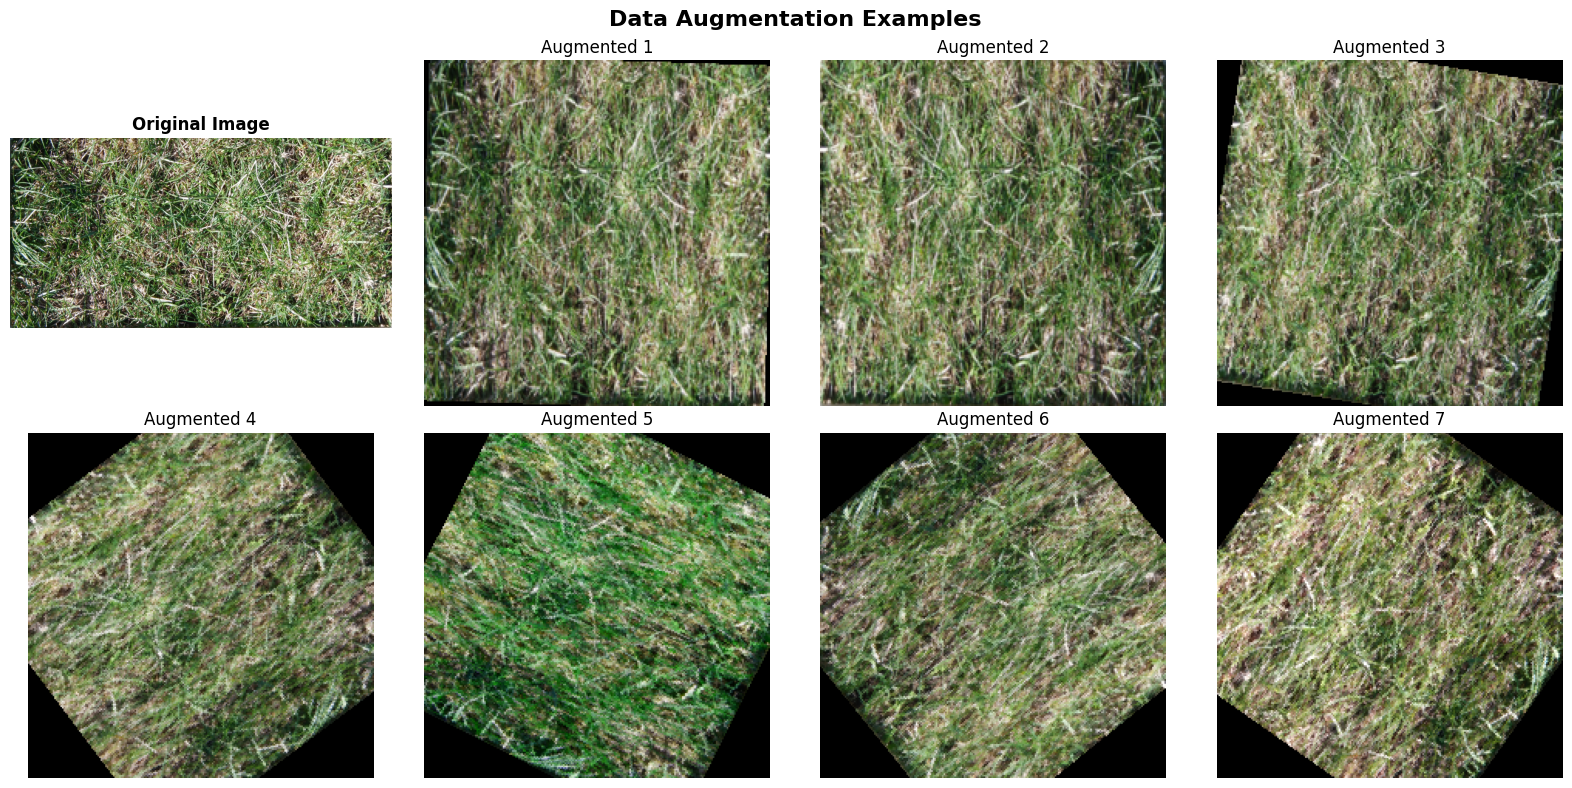

In [10]:
# Get one sample image
sample_idx = 0
original_img_path = PATH_DATA + "/" + str(df_pivoted.loc[sample_idx, 'image_path'])
original_img = Image.open(original_img_path).convert('RGB')

# Apply augmentation multiple times
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Show original
axes[0].imshow(original_img)
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Show augmented versions
for i in range(1, 8):
    augmented = train_transforms(original_img)
    
    # Ensure the augmented image is a Tensor
    if not isinstance(augmented, torch.Tensor):
        augmented = transforms.ToTensor()(augmented)

    augmented = augmented.to(DEVICE)
    
    # Denormalize for visualization
    mean_temp = torch.tensor(mean).view(3, 1, 1).to(DEVICE)
    std_temp = torch.tensor(std).view(3, 1, 1).to(DEVICE)
    img_denorm = augmented * std_temp + mean_temp
    img_denorm = torch.clamp(img_denorm, 0, 1)

    # Convert to numpy and transpose
    img_np = img_denorm.cpu().permute(1, 2, 0).numpy()

    axes[i].imshow(img_np)
    axes[i].set_title(f'Augmented {i}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
backbone = timm.create_model(MODEL, pretrained=True)
backbone.to(DEVICE)
backbone.eval()

backbone

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=

In [12]:
backbone(train_transforms(original_img).to(DEVICE).unsqueeze(0)).shape

torch.Size([1, 1000])

In [13]:
backbone.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [14]:
try:
    backbone_out_dim = backbone.fc.out_features
except Exception as e:
    backbone_out_dim = backbone.head.in_features
    dummy = torch.randn(1, 3, input_size, input_size)
    backbone_output = backbone(dummy)
    if hasattr(backbone_output, 'shape'):
        backbone_out_dim = backbone_output.shape[1]
    elif hasattr(backbone_output, 'last_hidden_state'):
        backbone_out_dim = backbone_output.last_hidden_state.size(-1)

print("Backbone output dimension:", backbone_out_dim)
    

Backbone output dimension: 1000


In [15]:
dummy = torch.randn(1, 3, input_size, input_size).to(DEVICE)
backbone_output = backbone.forward_features(dummy)
if hasattr(backbone_output, 'shape'):
    backbone_out_dim = backbone_output.shape[1]
elif hasattr(backbone_output, 'last_hidden_state'):
    backbone_out_dim = backbone_output.last_hidden_state.size(-1)

In [16]:
# Create dataset instance
train_dataset = BiomassDataset(
    df=df_pivoted,
    target_cols=USED_TARGETS,
    img_dir=PATH_TRAIN_IMG,
    transform=train_transforms,
    is_test=False
)

In [17]:
# Test it
sample = train_dataset[0]
print(f"Left image shape: {sample['left_image'].shape}")
print(f"Right image shape: {sample['right_image'].shape}")
print(f"Targets shape: {sample['targets'].shape}")
print(f"Image ID: {sample['image_id']}")
print(f"Target values: {sample['targets']}")
print()

# Test dataset with log transform
print(f"Original targets from df: {df_pivoted.iloc[0][USED_TARGETS].values}")
print(f"Log-transformed targets: {sample['targets']}")
print(
    f"Should be close to: {np.log1p(df_pivoted.iloc[0][USED_TARGETS].values.astype(np.float32))}")

Left image shape: torch.Size([3, 224, 224])
Right image shape: torch.Size([3, 224, 224])
Targets shape: torch.Size([3])
Image ID: ID1011485656
Target values: tensor([2.8493, 3.8974, 2.8493])

Original targets from df: [np.float64(16.275) np.float64(48.2735) np.float64(16.275)]
Log-transformed targets: tensor([2.8493, 3.8974, 2.8493])
Should be close to: [2.8492603 3.8973863 2.8492603]


## Spliting Data (StratifiedKFold)


In [18]:
df_with_folds = create_folds_with_date_groups(
    df_pivoted,
    n_folds=5,
    use_mass_stratification=True,
    n_mass_bins=5,  # 5 bins = quintiles
    mass_col='Dry_Total_g',
    random_state=SEED
)


Fold 0:
  Train samples: 283
  Val samples: 74
  ✓ No date overlap (train: 23 dates, val: 5 dates)

Fold 1:
  Train samples: 286
  Val samples: 71
  ✓ No date overlap (train: 22 dates, val: 6 dates)

Fold 2:
  Train samples: 287
  Val samples: 70
  ✓ No date overlap (train: 22 dates, val: 6 dates)

Fold 3:
  Train samples: 277
  Val samples: 80
  ✓ No date overlap (train: 22 dates, val: 6 dates)

Fold 4:
  Train samples: 295
  Val samples: 62
  ✓ No date overlap (train: 23 dates, val: 5 dates)
FOLD QUALITY VERIFICATION

Fold 0:
  Samples: 74
  State distribution:
    Vic: 39.2%
    NSW: 25.7%
    Tas: 24.3%
    WA: 10.8%
  Species distribution:
    Ryegrass_Clover: 24.3%
    Lucerne: 13.5%
    Ryegrass: 13.5%
    Phalaris_Clover: 13.5%
    Fescue: 12.2%
    Clover: 10.8%
    Phalaris_Ryegrass_Clover: 9.5%
    Mixed: 2.7%
  Season distribution:
    Winter: 74.3%
    Autumn: 13.5%
    Summer: 12.2%
  Mass bin distribution:
    mass_bin_0: 24.3%
    mass_bin_1: 20.3%
    mass_bin_2: 20.3

## Data Loaders

In [19]:
# Create dataset
train_dataset = BiomassDataset(
    df=df_pivoted,
    target_cols=USED_TARGETS,
    img_dir=PATH_TRAIN_IMG,
    transform=train_transforms,
    is_test=False
)

In [20]:
# Loop through folds
for fold_id in range(N_FOLDS):
    # Get loaders for this fold
    train_loader, val_loader = get_fold_loaders(
        df=df_with_folds,
        dataset=train_dataset,
        fold=fold_id,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
    )
    
    print_fold_loader_info(df_with_folds, fold_id, train_loader, val_loader)


Fold 0 DataLoaders Info:
  Train samples: 283
  Val samples: 74
  Train batches: 71
  Val batches: 19
  Train batch size: 4
  Val batch size: 4

Fold 1 DataLoaders Info:
  Train samples: 286
  Val samples: 71
  Train batches: 72
  Val batches: 18
  Train batch size: 4
  Val batch size: 4

Fold 2 DataLoaders Info:
  Train samples: 287
  Val samples: 70
  Train batches: 72
  Val batches: 18
  Train batch size: 4
  Val batch size: 4

Fold 3 DataLoaders Info:
  Train samples: 277
  Val samples: 80
  Train batches: 70
  Val batches: 20
  Train batch size: 4
  Val batch size: 4

Fold 4 DataLoaders Info:
  Train samples: 295
  Val samples: 62
  Train batches: 74
  Val batches: 16
  Train batch size: 4
  Val batch size: 4


## Ligtning Module


In [21]:
labels = [
    "Dry_Clover_g",
    "Dry_Dead_g",
    "Dry_Green_g",
    "Dry_Total_g",
    "GDM_g"
]

weights = {
    'Dry_Clover_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Green_g': 0.1,
    'Dry_Total_g': 0.5,
    'GDM_g': 0.2,
}


def competition_metric(y_true, y_pred) -> float:
    """Function to calculate the competition's official evaluation metric (weighted R2 score)."""
    # print("y_true", y_true)
    # print()
    # print("y_pred", y_pred)
    weights_array = np.array([weights[l] for l in labels])

    # Align with this calculation method
    y_weighted_mean = np.average(y_true, weights=weights_array, axis=1).mean()

    # For ss_res and ss_tot, also take the weighted average on axis=1, then the mean of the result
    ss_res = np.average((y_true - y_pred)**2,
                        weights=weights_array, axis=1).mean()
    ss_tot = np.average((y_true - y_weighted_mean)**2,
                        weights=weights_array, axis=1).mean()

    return 1 - ss_res / ss_tot

## Folds Training


In [22]:
train_loader, val_loader = get_fold_loaders(
    df=df_with_folds,
    dataset=train_dataset,
    fold=fold_id,
    batch_size=BATCH_SIZE
)

batch = next(iter(train_loader))

In [23]:
print(batch.keys())
batch

dict_keys(['left_image', 'right_image', 'image_id', 'targets'])


{'left_image': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],

In [24]:
# Train on all folds
fold_results = []

for fold_id in range(N_FOLDS):
    train_loader, val_loader = get_fold_loaders(
        df=df_with_folds,
        dataset=train_dataset,
        fold=fold_id,
        batch_size=BATCH_SIZE
    )

    model = BiomassConvNeXt(
        kaggle_score=competition_metric,
        backbone_name=MODEL,
        backbone_input_size=input_size,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        hidden_ratio=HIDDEN_RATIO,
        dropout=DROPOUT_RATE,
        use_log_target=USE_LOG_TARGET,
        freeze_backbone=True,
    )
    model.to(DEVICE)

    log_to_monitor = 'val/r2_global'

    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor=log_to_monitor,  # 'val_loss'
        dirpath=os.path.join(CHECKPOINTS_DIR, f'fold{fold_id}'),
        filename=f'{DESCRIPTION_FULL}-fold{fold_id}' +
        '-{epoch:02d}-{val_loss:.4f}-{val/r2_global:.4f}',
        save_top_k=3,  # Save top 3 instead of 1
        mode='max'  # or 'min' for val_loss
    )

    early_stopping_callback = EarlyStopping(
        monitor=log_to_monitor,  # 'val_loss'
        patience=7,
        mode='max',
        verbose=True,
        min_delta=1e-3
    )

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # Logger
    wandb_logger = WandbLogger(
        project=PROJECT_NAME,
        name=f'{DESCRIPTION_FULL}-fold{fold_id}',
        log_model='all',
        tags=['CNN', f'fold{fold_id}', FUSION_METHOD]
    )

    # Trainer
    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        accelerator=DEVICE.type,
        precision='16-mixed' if torch.cuda.is_available() else 32,
        accumulate_grad_batches=GRAD_ACCUM,
        callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor],
        logger=wandb_logger,
        log_every_n_steps=1,
        gradient_clip_val=1.0,
        gradient_clip_algorithm='norm',
        enable_progress_bar=True,
        deterministic=True
    )

    try:
        # Train
        trainer.fit(model, train_loader, val_loader)

        # Load best checkpoint
        best_model_path = checkpoint_callback.best_model_path
        logger.info(f"Loading best model from: {best_model_path}")
        best_model = BiomassConvNeXt.load_from_checkpoint(
                best_model_path)

        # Evaluate on validation set
        val_result = trainer.validate(best_model, val_loader, verbose=False)
        fold_results.append({
            'fold': fold_id,
            'val/loss_total': val_result[0]['val/loss_total'],
            log_to_monitor: val_result[0][log_to_monitor]
        })

    except SystemExit:
        logger.warning(
            f"Training interrupted during fold {fold_id}. Exiting gracefully.")
        wandb_logger.experiment.finish()

        # Clean up memory after each fold
        del model, trainer, wandb_logger
        del train_loader, val_loader

        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.synchronize()

        break

    finally:
        wandb_logger.experiment.finish()

        # Clean up memory after each fold
        del model, trainer, wandb_logger
        del train_loader, val_loader

        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.synchronize()

Loaded pretrained model from timm: seresnextaa101d_32x8d.sw_in12k_ft_in1k_288


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: Currently logged in as: dmykhailov (dmykhailov-kyiv-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory C:\_GitHub\CSIRO-Image2Biomass-Prediction\notebooks\kaggle\checkpoints\teacher\fold0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name         | Type       | Params | Mode  | FLOPs
------------------------------------------------------------
0 | backbone     | ResNet     | 91.5 M | train | 0    
1 | head_global  | Sequential | 10.5 M | train | 0    
  | other params | n/a        | 2      | n/a   | n/a  
------------------------------------------------------------
10.5 M    Trainable params
91.5 M    Non-trainable params
102 M     Total params
408.141   Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val/r2_global improved. New best score: -5.496


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/r2_global improved by 5.512 >= min_delta = 0.001. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/r2_global improved by 0.195 >= min_delta = 0.001. New best score: 0.211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...



[2025-12-18 15:33:27]


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
lr-AdamW,███▇▇▆▅▄▃▂▁
train/loss_global,█▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇███
val/loss_global,▅▄ ▁ █
val/r2_global,▃█▅▅▁▅▄█▃▄
epoch,9
lr-AdamW,5e-05
train/loss_global,0.18383
trainer/global_step,180
val/loss_global,26.28188


NameError: name 'wandb_logger' is not defined

In [ ]:
print("Training Summary")
print()
results_df = pd.DataFrame(fold_results)
print(results_df)
print(
    f"Mean Val Loss: {results_df['val_loss'].mean():.4f} ± {results_df['val_loss'].std():.4f}")